# F1 data analysis notebook 
#### @kevinofsydney

Notes:
- The 'KeyError' is because the name of the column gets consumed when it is turned into an index 
- df.describe() is useful
- oddsportal.com
- race_df['name'].unique()
- http://www.f1-predictor.com/category/data-science/
- https://www.f1hotornot.com/ - this is a very good form rating, and could be used to also indicate whether a driver is expected to overperform or underperform their average

"How should we apply cross-validation to data that are time-ordered (like F1 results)? The basic idea remains the same but instead of splitting the training data into 3 random folds, we break it in a way that the validation data always refer to a later period compared to the training data.

"Here’s how your CV would work: you train the model on the first 20 races and you make predictions for the next 10 ones. You calculate the relevant metrics. Then, you train the model on the first 30 races (or the races 11-30, this is a choice you have to take) and predict on the next 10. You keep doing this for the next 2 folds. Finally, you calculate the average performance."


### To do list
- Automate adding the column labels
- Calculate the average race result for each driver
- Create a working prototype to predict qualifier results
- Create a working prototype to predict race results

In [10]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


%matplotlib inline

OUTPUT = True

## Preprocessing

In [2]:
# Load the files
cir_df = pd.read_csv('circuits_l.csv')
conresult_df = pd.read_csv('constructor_results_l.csv')
constanding_df = pd.read_csv('constructor_standings_l.csv')
con_df = pd.read_csv('constructors_l.csv')
driver_df = pd.read_csv('driver_l.csv')
laptime_df = pd.read_csv('lap_times_l.csv')
quali_df = pd.read_csv('qualifying_l.csv')
race_df = pd.read_csv('races_l.csv')
result_df = pd.read_csv('results_l.csv')
status_df = pd.read_csv('status_l.csv')

# Set the correct indices 
race_df['date'] = pd.to_datetime(race_df['date'], dayfirst=True)

# driver_df.set_index('driverId', inplace=True)
quali_df.set_index('qualifyId', inplace=True)
laptime_df.set_index('raceId', inplace=True)
race_df.set_index('date', inplace=True)
result_df.set_index('resultId', inplace=True)

# race_df.sort_values('raceId', inplace=True)
race_df.sort_index(inplace=True)

# Remove unnecessary columns, or columns I still need to implement processing for
result_df = result_df.drop('number', axis=1)

resultsm_df = result_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']]

def label_points(row):
    if row['positionOrder'] <= 3:
        return 1 #'top3'
    elif row['positionOrder'] > 3 and row['positionOrder'] <= 6:
        return 2 # 'top6'
    elif row['positionOrder'] > 6 and row['positionOrder'] <= 10:
        return 3 #'top10'
    else:
        return 4 #'no_points'

resultsm_df = resultsm_df.merge(race_df[['raceId', 'circuitId']], how='left', on=['raceId'])
resultsm_df['raceresult'] = resultsm_df.apply(label_points, axis=1)
resultsm_df.head(5)

,raceId,driverId,constructorId,grid,positionOrder,circuitId,raceresult
0,900,3,131,3,1,1,1
1,900,825,1,4,2,1,1
2,900,18,1,10,3,1,1
3,900,4,6,5,4,1,2
4,900,822,3,15,5,1,2


In [3]:
# Converting the constructors to strings, and then applying OHE. 
# Converting constructor names to strings allows for the columns to be named informatively

def name_constructors(row):
    if row['constructorId'] == 1:
        return 'MCL'
    elif row['constructorId'] == 3:
        return 'WIL'
    elif row['constructorId'] == 4:
        return 'REN'
    elif row['constructorId'] == 5:
        return 'TOR'
    elif row['constructorId'] == 6:
        return 'FER'
    elif row['constructorId'] == 9:
        return 'RBR'
    elif row['constructorId'] == 10:
        return 'RCP'
    elif row['constructorId'] == 15:
        return 'SAU'
    elif row['constructorId'] == 51:
        return 'ALF'
    elif row['constructorId'] == 131:
        return 'MER'
    elif row['constructorId'] == 206:
        return 'RUS'
    elif row['constructorId'] == 207:
        return 'CAT'
    elif row['constructorId'] == 208:
        return 'LOT'
    elif row['constructorId'] == 209:
        return 'MAN'
    elif row['constructorId'] == 210:
        return 'HAA'
    elif row['constructorId'] == 211:
        return 'RCP'
    
# Converting the constructorId to String and converting it to categorical
if 'constructorId' in resultsm_df.columns:
    resultsm_df['cstrIdString'] = resultsm_df.apply(name_constructors, axis=1)
    resultsm_df['cstrIdString'] = pd.Categorical(resultsm_df['cstrIdString'])

    # Getting the dummies of the categories
    cstrStringDummies = pd.get_dummies(resultsm_df['cstrIdString'], prefix='cstr')

    # Add the dummy columns back into the main results df 
    resultsm_df = pd.merge(resultsm_df, cstrStringDummies, left_index=True, right_index=True)

    # Save the constructorIdStrings to put back in after predictions
    cstrIdStrings = resultsm_df[['cstrIdString']]

# Drop the original columns from the testing data so that only the OHE form of the cstr remains
if 'cstrIdString' in resultsm_df.columns:
    resultsm_df = resultsm_df.drop(columns=['cstrIdString'])

if 'constructorId' in resultsm_df.columns: 
    resultsm_df = resultsm_df.drop(columns=['constructorId'])

if 'raceId' in resultsm_df.columns: 
    resultsm_df = resultsm_df.drop('raceId', axis=1)

In [4]:
# Splitting into training and test sets
# data - resultsm_df[['circuitId', 'driverId', 'constructorId', 'grid']]
# target - resultsm_df[['raceresult']]

from sklearn.model_selection import train_test_split

# Driver-OHE version
data_train, data_test, label_train, label_test = train_test_split(resultsm_df.drop(columns=['raceresult']),
                                                                  resultsm_df[['raceresult']],
                                                                  test_size=0.25, 
                                                                  random_state=1)

## Modelling

### - SVM

In [42]:
### SVM
# Accuracy before constructor OHE: 0.6308
# Accuracy after constructor OHE: 1.0 ???

from sklearn import svm
clf_svm = svm.SVC(kernel='linear', C=1).fit(data_train, np.ravel(label_train))
pred_svm = clf_svm.predict(data_test)
pred_svm = pd.DataFrame(data=pred_svm, columns=['svm_preds'])

# Manually finding the accuracy since the sklearn accuracy_score library doesn't work here...
x = pd.merge(pred_svm, label_test, left_index=True, right_index=True)
x = x.values.tolist()

correct = 0
for index, row in enumerate(x):
    if row[0] is row[1]:
        correct += 1

# print("SVM accuracy:", accuracy_score(label_test, pred_svm, normalize = True)) Broken
print("SVM accuracy:", correct/len(x))

# Create the output file 
svm_result = pd.merge(data_test[['driverId', 'grid', 'positionOrder', 'circuitId']], 
                     cstrIdStrings, left_index=True, right_index=True)
svm_result = pd.merge(svm_result, pred_svm, left_index=True, right_index=True)
svm_result = pd.merge(svm_result, label_test, left_index=True, right_index=True)


if OUTPUT:
    svm_result.to_csv('output/svm_predictions.csv', index=False)

# Accuracy stats (not functional for SVM atm)
# svm_conf = confusion_matrix(label_test, pred_svm)
# print(svm_conf)
# svm_creport = classification_report(label_test, pred_svm)
# print()
# print(svm_creport)

SVM accuracy: 0.3511450381679389


### - Naive-Bayes

In [68]:
### Naive-Bayes
# Accuracy before constructor OHE: 0.6066
# Accuracy after constructor OHE: 0.7643

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
clf_nb = gnb.fit(data_train, np.ravel(label_train))
nb_preds = clf_nb.predict(data_test)

# Print the accuracy score of the model
print("Naive-Bayes accuracy: ", accuracy_score(label_test, pred_nb, normalize = True))

nb_preds = pd.DataFrame(data=nb_preds, columns=['nb_preds'])

# Create the output file 
nb_result = pd.merge(data_test[['driverId', 'grid', 'positionOrder', 'circuitId']], 
                     cstrIdStrings, left_index=True, right_index=True)
nb_result = pd.merge(nb_result, nb_preds, left_index=True, right_index=True)
nb_result = pd.merge(nb_result, label_test, left_index=True, right_index=True)

if OUTPUT:
    nb_result.to_csv('output/nb_predictions.csv', index=False)

nb_mat = confusion_matrix(label_test, nb_preds)
print(nb_conf)
nb_creport = classification_report(label_test, nb_preds)
print()
print(nb_creport)

Naive-Bayes accuracy:  0.7642980935875217
[[ 89   0   1   0]
 [ 35  34   4   0]
 [  0  43  69   3]
 [  0   0  50 249]]

              precision    recall  f1-score   support

           1       0.72      0.99      0.83        90
           2       0.44      0.47      0.45        73
           3       0.56      0.60      0.58       115
           4       0.99      0.83      0.90       299

    accuracy                           0.76       577
   macro avg       0.68      0.72      0.69       577
weighted avg       0.79      0.76      0.77       577



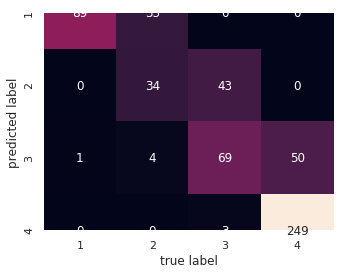

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

sns.heatmap(nb_mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[1, 2, 3, 4],
            yticklabels=[1, 2, 3, 4])
plt.xlabel('true label')
plt.ylabel('predicted label');

### - K-means

In [113]:
from sklearn.cluster import KMeans

# Brute force testing from numbers 1-100 showed that the 'optimal' number of clusters is 5 - 6 
# but this varies wildly

hiscore = 0
hicluster = 0

km_clf = KMeans(n_clusters = 4)
km_clf.fit(data_train)
km_pred = km_clf.predict(data_test)
km_pred = pd.DataFrame(data=km_pred, columns=['km_preds'])

accuracy_score(label_test, km_pred)

0.1195840554592721

In [118]:
km_mat = confusion_matrix(label_test, km_pred)
print(km_mat)
km_creport = classification_report(label_test, km_pred)
print()
print(km_creport)

[[  0   0   0   0   0]
 [ 64   2   1  23   0]
 [ 31   5   1  36   0]
 [ 28  15   6  66   0]
 [ 55  42  25 177   0]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.03      0.02      0.03        90
           2       0.03      0.01      0.02        73
           3       0.22      0.57      0.32       115
           4       0.00      0.00      0.00       299

    accuracy                           0.12       577
   macro avg       0.06      0.12      0.07       577
weighted avg       0.05      0.12      0.07       577



## Code Graveyard

In [7]:
# Find a driverId via their code
code = 'RAI'
did = driver_df[ driver_df['code'] == code]['driverId']
print("INFO: driverID for", code, "is:", int(did))

### Return the result for a single driver
resultsm_df[resultsm_df['driverId'] == int(did)].head(20)

resultsm_df['driverId'].nunique()

INFO: driverID for RAI is: 8


45

In [8]:
# Merging the quali, driver_details and results dataframes together
quali_rdf = quali_df[['raceId', 'driverId', 'q1', 'q2', 'q3']]
master = driver_df[['driverId', 'code']].merge(quali_rdf, how='inner', on=['driverId'])
master = master.merge(result_df, how='inner', left_on=['raceId', 'driverId'], right_on=['raceId', 'driverId'])
# master.sort_values(by=['raceId', 'positionOrder']).head(50)
master.head(5)
# Train the model

,driverId,code,raceId,q1,q2,q3,constructorId,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,HAM,900,01:31.7,01:42.9,01:44.2,131,1,\N,R,19,0,2,\N,\N,2,20,01:49.9,173.636,5
1,1,HAM,901,01:57.2,01:59.0,01:59.4,131,1,1,1,1,25,56,40:26.0,6025974,53,1,01:43.1,193.611,1
2,1,HAM,902,01:35.3,01:33.9,01:33.5,131,2,1,1,1,25,57,39:42.7,5982743,49,2,01:37.1,200.634,1
3,1,HAM,903,01:55.5,01:54.0,01:53.9,131,1,1,1,1,25,54,33:28.3,5608338,42,2,01:41.2,193.916,1
4,1,HAM,904,01:27.2,01:26.2,01:25.2,131,1,1,1,1,25,66,41:05.2,6065155,54,3,01:29.5,187.275,1


In [9]:
# Replace raceId with circuitId
from pandas.plotting import scatter_matrix
# To make this work, add back constructorId to the dataframe 
# scatter_matrix(resultsm_df[['driverId','constructorId','grid','positionOrder','circuitId', 'raceresult']], figsize=(10,10))